In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

<ipython-input-1-505314c94db7>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add, Flatten, Reshape
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, Multiply
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix

mpl.style.use('seaborn')

<ipython-input-3-09b92ded8355>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [ ]:
from src.se_resnet_models import SE_Resnet_34, SE_Resnet_18
from src.resnet_models import Resnet_18, Resnet_34
from src.preprocessing import signal_clean
from src.modeling_results import plot_roc_curve, plot_confusion_matrix, get_eval_by_threshold, acc_graph, loss_graph

importing Jupyter notebook from _SE_ResNet_models.ipynb
importing Jupyter notebook from _ResNet_models.ipynb
importing Jupyter notebook from _preprocessing.ipynb
importing Jupyter notebook from _getModelingResults.ipynb


In [ ]:
result = pd.read_csv('./data/shaoxingECG.csv')

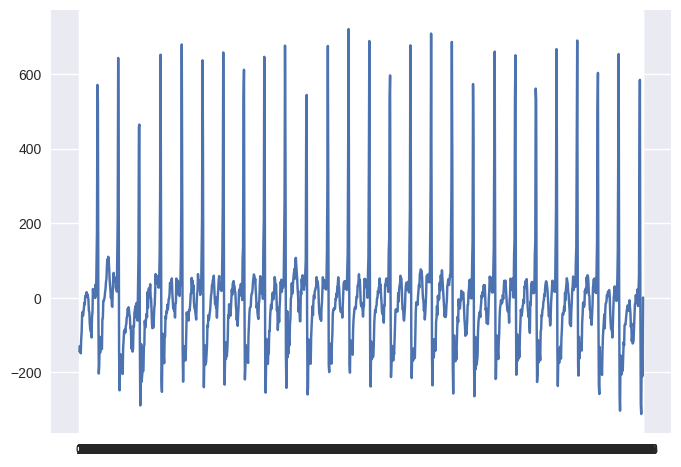

In [ ]:
afibdf = result[result['AFIB'] == 1].reset_index(drop=True)

plt.plot(afibdf.iloc[1])

In [ ]:
X = result.drop(['AFIB'],axis=1).values
Y = result['AFIB'].values

In [ ]:
result['AFIB'].value_counts()

0.0    8421
1.0    2225
Name: AFIB, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_cleaned = signal_clean(X, sampling_rate=125)
X_cleaned = pd.DataFrame(X_cleaned).T
X_processed = pd.DataFrame(std_scaler.fit_transform(X_cleaned)).T


In [ ]:
n=50

plt.figure(figsize = (16, n*3))
for i in range(n):
  plt.subplot(n,2,i*2+1)
  signal = X.values[i,:]
  plt.plot(signal, label = 'before')
  plt.legend()

  plt.subplot(n,2,i*2+2)
  new_sig = np.array(X_processed.iloc[i]).flatten()
  plt.plot(new_sig, label = 'after')
  plt.legend()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics
import numpy as np

333/333 [==============================] - 15s 12ms/step
0.9834466268784967


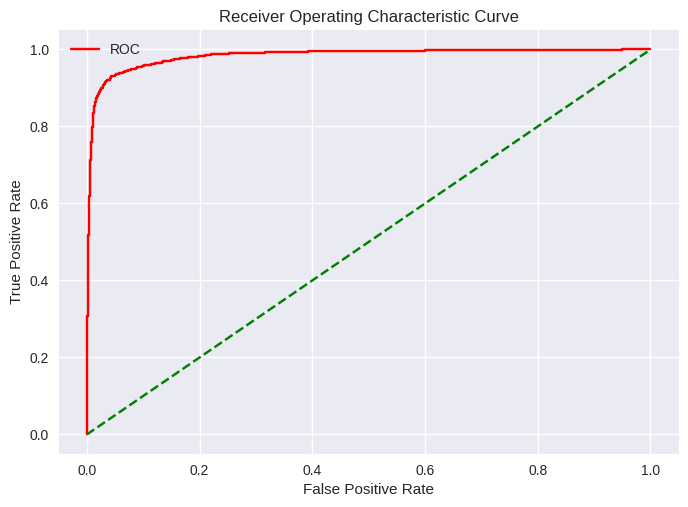

Confusion matrix, without normalization
[[7954  467]
 [ 141 2084]]


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Accuracy,0.8346,0.8870,0.9144,0.9311,0.9429,0.9514,0.9561,0.9586,0.9602
PPV,0.5593,0.6558,0.7238,0.7746,0.8169,0.8544,0.8792,0.9044,0.9340
Sensitivity,0.9834,0.9667,0.9551,0.9452,0.9366,0.9254,0.9160,0.8966,0.8710
Specificity,0.7953,0.8659,0.9037,0.9273,0.9445,0.9583,0.9667,0.9749,0.9837
F1 score,0.7131,0.7815,0.8235,0.8514,0.8727,0.8885,0.8972,0.9005,0.9014


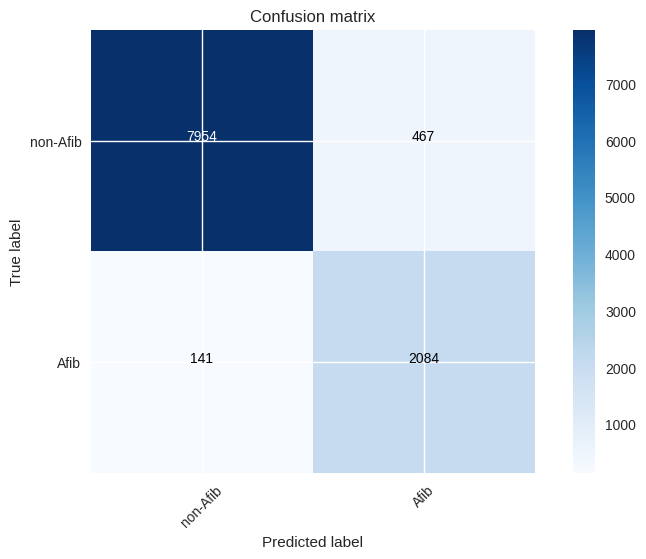

In [ ]:
model = SE_Resnet_34(input_shape = (1250,1))
model.load_weights('./models/SE_resnet_34_smallBatch.hdf5')

## roc curve
test_input = X_processed
test_target = Y
prob = model.predict(test_input)
fper, tper, thresholds = roc_curve(test_target, prob)
print(metrics.auc(fper, tper))
plot_roc_curve(fper, tper)

## confusion matrix

y_pred = (prob > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(test_target, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non-Afib', 'Afib'],
                      title='Confusion matrix')

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = prob
resultByThreshold = get_eval_by_threshold(test_target, pred_proba.reshape(-1, 1), thresholds)

round(pd.DataFrame(resultByThreshold, columns = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'F1 score', 'Threshold']).set_index('Threshold').T, 4)

333/333 [==============================] - 3s 6ms/step
0.9562619934913918


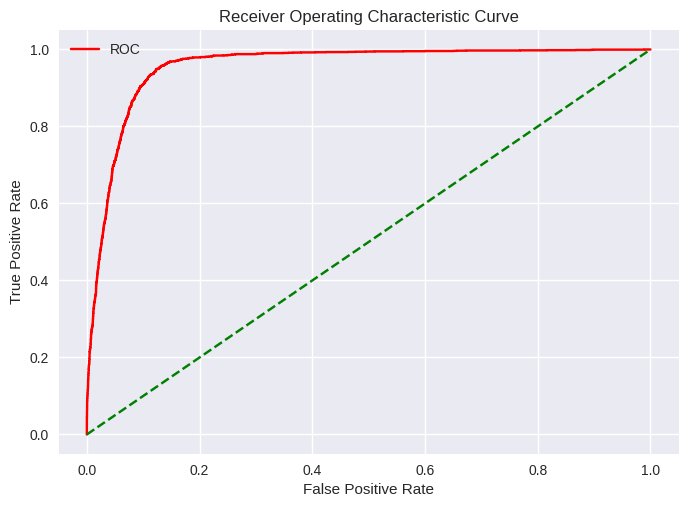

Confusion matrix, without normalization
[[7238 1183]
 [  83 2142]]


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Accuracy,0.8056,0.8403,0.8595,0.8724,0.8811,0.8882,0.8936,0.9012,0.9081
PPV,0.5183,0.5685,0.6009,0.6258,0.6442,0.6616,0.6774,0.7025,0.7401
Sensitivity,0.9843,0.9793,0.9757,0.9690,0.9627,0.9524,0.9371,0.9146,0.8638
Specificity,0.7583,0.8036,0.8288,0.8469,0.8595,0.8713,0.8821,0.8976,0.9198
F1 score,0.6791,0.7194,0.7437,0.7605,0.7719,0.7808,0.7863,0.7946,0.7972


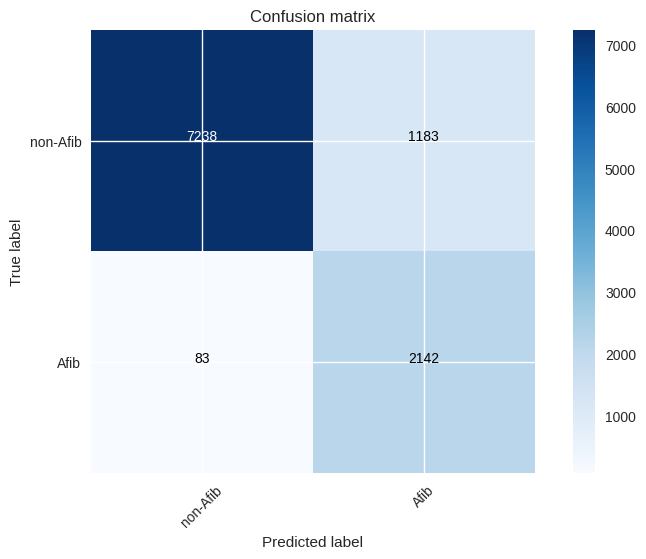

In [ ]:
model = SE_Resnet_18(input_shape = (1250,1))
model.load_weights('./models/SE_resnet_18_smallBatch.hdf5')

## roc curve
test_input = X_processed
test_target = Y
prob = model.predict(test_input)
fper, tper, thresholds = roc_curve(test_target, prob)
print(metrics.auc(fper, tper))
plot_roc_curve(fper, tper)

## confusion matrix

y_pred = (prob > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(test_target, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non-Afib', 'Afib'],
                      title='Confusion matrix')

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = prob
resultByThreshold = get_eval_by_threshold(test_target, pred_proba.reshape(-1, 1), thresholds)

round(pd.DataFrame(resultByThreshold, columns = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'F1 score', 'Threshold']).set_index('Threshold').T, 4)

333/333 [==============================] - 3s 6ms/step
0.958755865819667


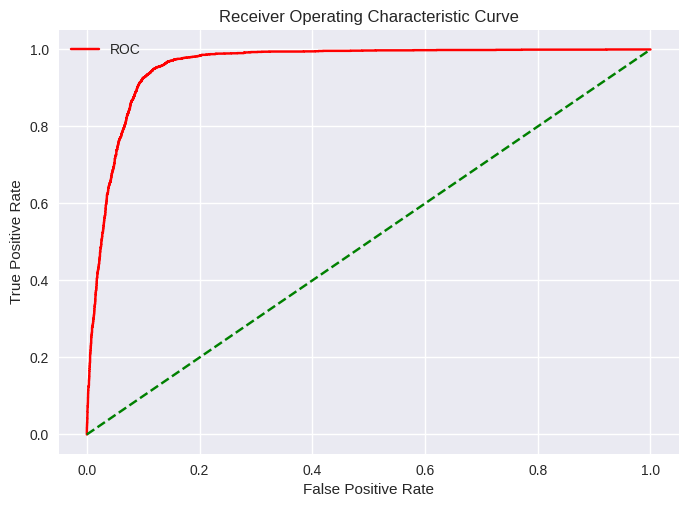

Confusion matrix, without normalization
[[7154 1267]
 [  64 2161]]


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Accuracy,0.7756,0.8178,0.8453,0.8612,0.8750,0.8860,0.8969,0.9057,0.9089
PPV,0.4821,0.5346,0.5763,0.6037,0.6304,0.6553,0.6833,0.7112,0.7446
Sensitivity,0.9924,0.9883,0.9811,0.9775,0.9712,0.9587,0.9443,0.9240,0.8584
Specificity,0.7183,0.7727,0.8094,0.8304,0.8495,0.8668,0.8843,0.9008,0.9222
F1 score,0.6489,0.6939,0.7261,0.7464,0.7645,0.7785,0.7928,0.8038,0.7975


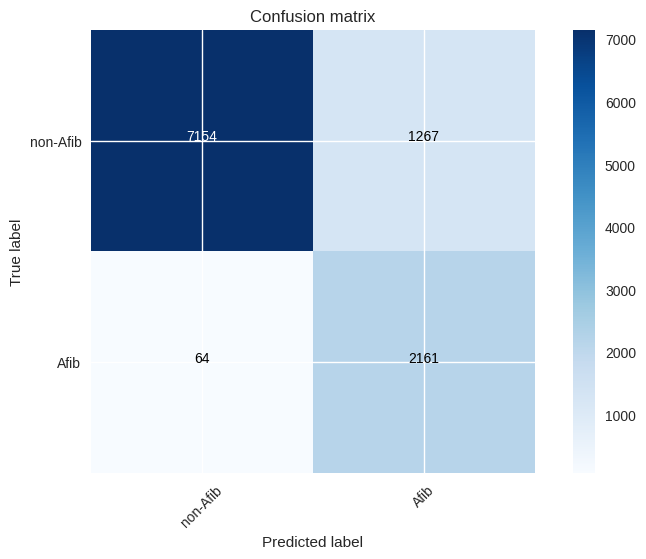

In [ ]:
model = Resnet_18(input_shape = (1250,1))
model.load_weights('./models/Resnet_18_smallBatch.hdf5')

## roc curve
test_input = X_processed
test_target = Y
prob = model.predict(test_input)
fper, tper, thresholds = roc_curve(test_target, prob)
print(metrics.auc(fper, tper))
plot_roc_curve(fper, tper)

## confusion matrix

y_pred = (prob > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(test_target, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non-Afib', 'Afib'],
                      title='Confusion matrix')

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = prob
resultByThreshold = get_eval_by_threshold(test_target, pred_proba.reshape(-1, 1), thresholds)

round(pd.DataFrame(resultByThreshold, columns = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'F1 score', 'Threshold']).set_index('Threshold').T, 4)


333/333 [==============================] - 6s 13ms/step
0.984039499965976


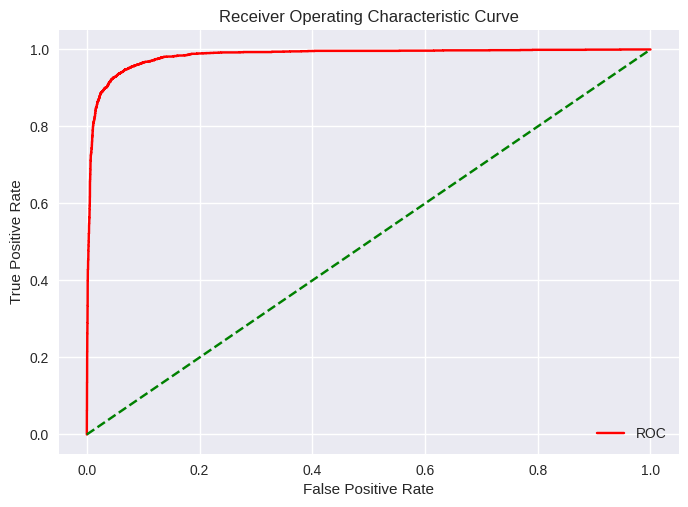

Confusion matrix, without normalization
[[7792  629]
 [ 106 2119]]


Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Accuracy,0.8841,0.9030,0.9156,0.9236,0.9310,0.9381,0.9475,0.9513,0.9565
PPV,0.6468,0.6907,0.7235,0.7474,0.7711,0.7986,0.8389,0.8693,0.9075
Sensitivity,0.9811,0.9703,0.9645,0.9587,0.9524,0.9411,0.9267,0.9029,0.8818
Specificity,0.8584,0.8852,0.9026,0.9144,0.9253,0.9373,0.9530,0.9641,0.9762
F1 score,0.7796,0.8070,0.8268,0.8399,0.8522,0.8640,0.8806,0.8858,0.8945


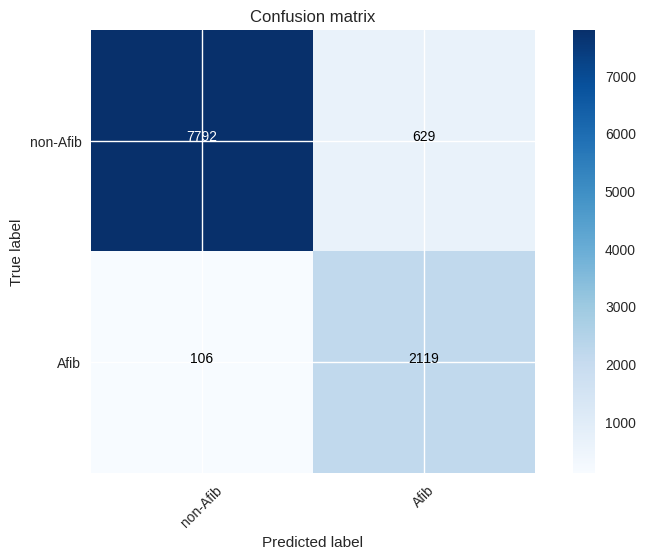

In [ ]:
model = Resnet_34(input_shape = (1250,1))
model.load_weights('./models/Resnet_34_smallBatch.hdf5')

## roc curve
test_input = X_processed
test_target = Y
prob = model.predict(test_input)
fper, tper, thresholds = roc_curve(test_target, prob)
print(metrics.auc(fper, tper))
plot_roc_curve(fper, tper)

## confusion matrix

y_pred = (prob > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(test_target, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non-Afib', 'Afib'],
                      title='Confusion matrix')

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = prob
resultByThreshold = get_eval_by_threshold(test_target, pred_proba.reshape(-1, 1), thresholds)

round(pd.DataFrame(resultByThreshold, columns = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'F1 score', 'Threshold']).set_index('Threshold').T, 4)